## Вычисление ограничительной рамки

In [1]:
from osgeo import ogr

In [2]:
shapefile = ogr.Open("input/TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp")
layer = shapefile.GetLayer(0)

In [3]:
countries = [] # List of (code, name, minLat, maxLat,
               # minLong, maxLong) tuples.

Согласно файлу Readme. txt, атрибуты в файле фигур содержат трехбуквенный код ISO-3166 страны (поле IS03), а также ее название  (поле NAME), которые позволяют получить код и название страны геообъекта. 

Кроме того, мы можем получить многоугольник границы страны при помощи метода GetGeometryRef()

Для обозначения ограничительной рамки геометрии геообъекта в библиотеке 0GR используется такое понятие, как огибающая линия, ограничительную рамку можно получить следующим образом: minLong,maxLong,minLat,maxLat = geometry.GetEnvelope()

In [4]:
for i in range(layer.GetFeatureCount()):
    feature = layer.GetFeature(i)
    countryCode = feature.GetField("ISO3")
    countryName = feature.GetField("NAME")
    geometry = feature.GetGeometryRef()
    minLong,maxLong,minLat,maxLat = geometry.GetEnvelope()

    countries.append((countryName, countryCode,
                      minLat, maxLat, minLong, maxLong))

In [5]:
countries.sort()

for name,code,minLat,maxLat,minLong,maxLong in countries:
    print("{} ({}) lat={:.4f}..{:.4f},long={:.4f}..{:.4f}"
          .format(name,code,minLat,maxLat,minLong,maxLong))

Afghanistan (AFG) lat=29.4061..38.4721,long=60.5042..74.9157
Albania (ALB) lat=39.6447..42.6619,long=19.2825..21.0542
Algeria (DZA) lat=18.9764..37.0914,long=-8.6672..11.9865
American Samoa (ASM) lat=-14.3756..-14.1664,long=-170.8261..-169.4383
Andorra (AND) lat=42.4361..42.6564,long=1.4214..1.7817
Angola (AGO) lat=-18.0164..-4.3890,long=11.6633..24.0844
Anguilla (AIA) lat=18.1644..18.2767,long=-63.1678..-62.9695
Antarctica (ATA) lat=-90.0000..-60.5019,long=-180.0000..180.0000
Antigua and Barbuda (ATG) lat=16.9897..17.7250,long=-61.8911..-61.6664
Argentina (ARG) lat=-55.0517..-21.7805,long=-73.5836..-53.6497
Armenia (ARM) lat=38.8411..41.2971,long=43.4539..46.6225
Aruba (ABW) lat=12.4111..12.6311,long=-70.0633..-69.8733
Australia (AUS) lat=-54.7539..-10.0514,long=112.9072..159.1019
Austria (AUT) lat=46.4075..49.0189,long=9.5336..17.1664
Azerbaijan (AZE) lat=38.3892..41.8971,long=44.7789..50.3750
Bahamas (BHS) lat=20.9153..26.9292,long=-78.9789..-72.7375
Bahrain (BHR) lat=25.5719..26.28

## Вычисление границы между Таиландом и Мьянмой

In [6]:
import os, os.path, shutil
from osgeo import ogr, osr
import shapely.wkt

shapefile = ogr.Open("input/TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp")
layer = shapefile.GetLayer(0)

In [7]:
# идентифицируем геообъекты по двухсимвольным кодам ISO-3166 стран

thailand = None
myanmar = None

for i in range(layer.GetFeatureCount()):
    feature = layer.GetFeature(i)
    if feature.GetField("ISO2") == "TH":
        geometry = feature.GetGeometryRef()
        thailand = shapely.wkt.loads(geometry.ExportToWkt())
    elif feature.GetField("ISO2") == "MM":
        geometry = feature.GetGeometryRef()
        myanmar = shapely.wkt.loads(geometry.ExportToWkt())

In [8]:
# общая граница, посчитанная через shapely
commonBorder = thailand.intersection(myanmar)

if os.path.exists("output/common-border"):
    shutil.rmtree("output/common-border")
os.mkdir("output/common-border")

spatialReference = osr.SpatialReference()
spatialReference.SetWellKnownGeogCS('WGS84')

driver = ogr.GetDriverByName("ESRI Shapefile")
dstPath = os.path.join("output/common-border", "border.shp")
dstFile = driver.CreateDataSource(dstPath)
dstLayer = dstFile.CreateLayer("layer", spatialReference)

wkt = shapely.wkt.dumps(commonBorder)

feature = ogr.Feature(dstLayer.GetLayerDefn())
feature.SetGeometry(ogr.CreateGeometryFromWkt(wkt))
dstLayer.CreateFeature(feature)

0

In [9]:
del dstFile

## Анализ высот на основе цифровой карты местности

Файлы с цифровой картой местности (ЦКМ), англ, термин Digital Elevation Map (DEM), иногда также именуемые файлами с цифровой сеткой высот, - это растровый формат геоданных, в котором значения каждой ячейки («пиксела») обо? значают высоту точки, расположенной на поверхности Земли

In [18]:
import sys, struct
from osgeo import gdal
from osgeo import gdalconst

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
# ограничим геокоординаты Новой Зеландии
minLat  = -48
maxLat  = -33
minLong = 165
maxLong = 179

In [12]:
# загрузим датасет
dataset = gdal.Open("input/ngdc/l10g")
# получим растровый канал с отдельными значениями высоты
band = dataset.GetRasterBand(1)

In [13]:
# получим геотрансформацию набора данных
t = dataset.GetGeoTransform()

In [14]:
# переведем геоокоорджинаты в прямоугольные
tInverse = gdal.InvGeoTransform(t)

x1, y1 = gdal.ApplyGeoTransform(tInverse, minLong, minLat)
x2, y2 = gdal.ApplyGeoTransform(tInverse, maxLong, maxLat)

minX = int(min(x1, x2))
maxX = int(max(x1, x2))
minY = int(min(y1, y2))
maxY = int(max(y1, y2))

Зная прямоугольные координаты x и у интересующего нас участка ЦКМ, мы
можем воспользоваться библиотекой GDAL, чтобы прочитать отдельные значения высоты

In [38]:
# посчитаем через- struct
width = (maxX - minX) + 1
fmt = "<" + ("h" * width)

histogram = {} # Maps elevation to number of occurrences.

for y in range(minY, maxY + 1):
    
    scanline = band.ReadRaster(minX, y, width, 1,
                               width, 1,
                               gdalconst.GDT_Int16)
    values = struct.unpack(fmt, scanline)

    for value in values:
        if value != band.GetNoDataValue():
            try:
                histogram[value] += 1
            except KeyError:
                histogram[value] = 1
            
for height in sorted(histogram.keys()):
    print(height, histogram[height])

1 6641
2 909
3 1628
4 774
5 716
6 1289
7 669
8 633
9 944
10 668
11 691
12 769
13 707
14 790
15 2245
16 780
17 706
18 751
19 625
20 679
21 763
22 712
23 688
24 917
25 733
26 763
27 783
28 808
29 809
30 2583
31 821
32 747
33 780
34 663
35 639
36 628
37 611
38 653
39 600
40 612
41 622
42 609
43 581
44 649
45 956
46 649
47 597
48 661
49 667
50 635
51 623
52 616
53 693
54 653
55 645
56 688
57 756
58 735
59 834
60 2111
61 688
62 634
63 632
64 621
65 596
66 558
67 624
68 570
69 558
70 568
71 540
72 550
73 570
74 666
75 634
76 714
77 595
78 575
79 540
80 536
81 569
82 531
83 618
84 589
85 628
86 609
87 606
88 579
89 654
90 687
91 1398
92 600
93 583
94 557
95 577
96 527
97 568
98 547
99 540
100 548
101 526
102 504
103 506
104 532
105 513
106 555
107 529
108 540
109 534
110 509
111 492
112 546
113 544
114 498
115 519
116 586
117 515
118 545
119 561
120 599
121 1261
122 610
123 593
124 582
125 529
126 589
127 552
128 561
129 534
130 547
131 526
132 539
133 530
134 541
135 517
136 563
137 640
138 

2418 3
2421 1
2424 1
2425 1
2426 2
2427 2
2429 2
2430 2
2434 2
2436 3
2437 2
2438 1
2440 1
2442 1
2448 1
2449 1
2451 1
2453 2
2455 1
2456 2
2457 3
2460 1
2462 1
2463 1
2464 1
2470 1
2472 1
2479 1
2482 1
2483 1
2485 2
2487 2
2494 1
2495 1
2500 1
2501 2
2503 1
2516 1
2517 1
2520 1
2521 1
2522 1
2523 1
2524 1
2525 2
2529 1
2531 2
2532 1
2538 2
2542 1
2543 1
2544 1
2546 2
2552 1
2554 1
2557 1
2566 1
2569 1
2571 1
2595 1
2600 1
2605 1
2606 1
2612 1
2615 1
2616 1
2619 1
2633 1
2636 1
2640 1
2648 1
2649 1
2655 1
2658 1
2691 1
2699 1
2706 1
2707 1
2714 1
2748 1
2765 1
2781 1
2801 1
2808 1
2810 1
2816 1
2834 1
2860 1
2862 1
2873 1
2883 3
2932 1
2971 1
2983 1
3018 1
3097 1
3119 2
3173 1


In [28]:
np_values = band.ReadAsArray()
for row in range(minY, maxY + 1):
    print(np_values[row])

[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -50

[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -500 -500]
[-500 -500 -500 ... -500 -50

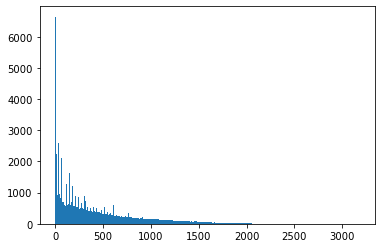

In [58]:
fig, ax = plt.subplots()
ax.bar(histogram.keys(), histogram.values(), width=10)
plt.show()

# Смена датумов и проекций

Датум - это математи? ческая модель фигуры Земли, тогда как проекция - метод трансляции точек на поверхности Земли в точки на двумерной карте

## смена проекции для совмещения файлов фигур с географическими и UTM-координатами

обратимся к двум файлам фигур с разными картографическими проекциями